In [2]:
!pip install pytesseract

You should consider upgrading via the '/Users/steffencruz/Desktop/py/opentensor/ocr_subnet/env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os

import pytesseract
import pdf2image

import pandas as pd
from PIL import Image


In [29]:
# Path to the image you want to extract text from
path = os.path.join(os.getcwd(), 'sample_invoice.pdf')

# Read the pdf into memory
image = pdf2image.convert_from_path(path)[0]
# convert to PIL image
image = image.convert('RGB')


In [30]:

# Optional: Apply image processing to clean up the image
# and improve OCR accuracy. For example, thresholding:
# image = image.convert('L')  # Convert image to grayscale
# threshold = 200
# image = image.point(lambda p: p > threshold and 255)

# Use Tesseract to do OCR on the image
text = pytesseract.image_to_string(image)

# Print the text
print(text)


Hess-Walker Invoice Date: June 11, 2016
7257 Brown Camp Apt. 305miMeadowsshire, IL 82196 Invoice #: INVO03535
Lake Cynthiabury, 84202

Bill To: Dr. Evan Henry

Description Qty Cost
Analytics 4 $400.00
Branding 4 $750.00
Domain registration 2 $10.00
Email marketing 5 $150.00
Graphic design 1 $310.00
PPC advertising 5 $200.00
SEO 3 $100.00
Social media marketing 4 $400.00
Support 1 $80.00
Training 2 $1200.00
Web design 5 $500.00
Web development 2 $500.00
Web hosting 3 $100.00

Total: $14,860.00

Terms: Payment due within 30 days



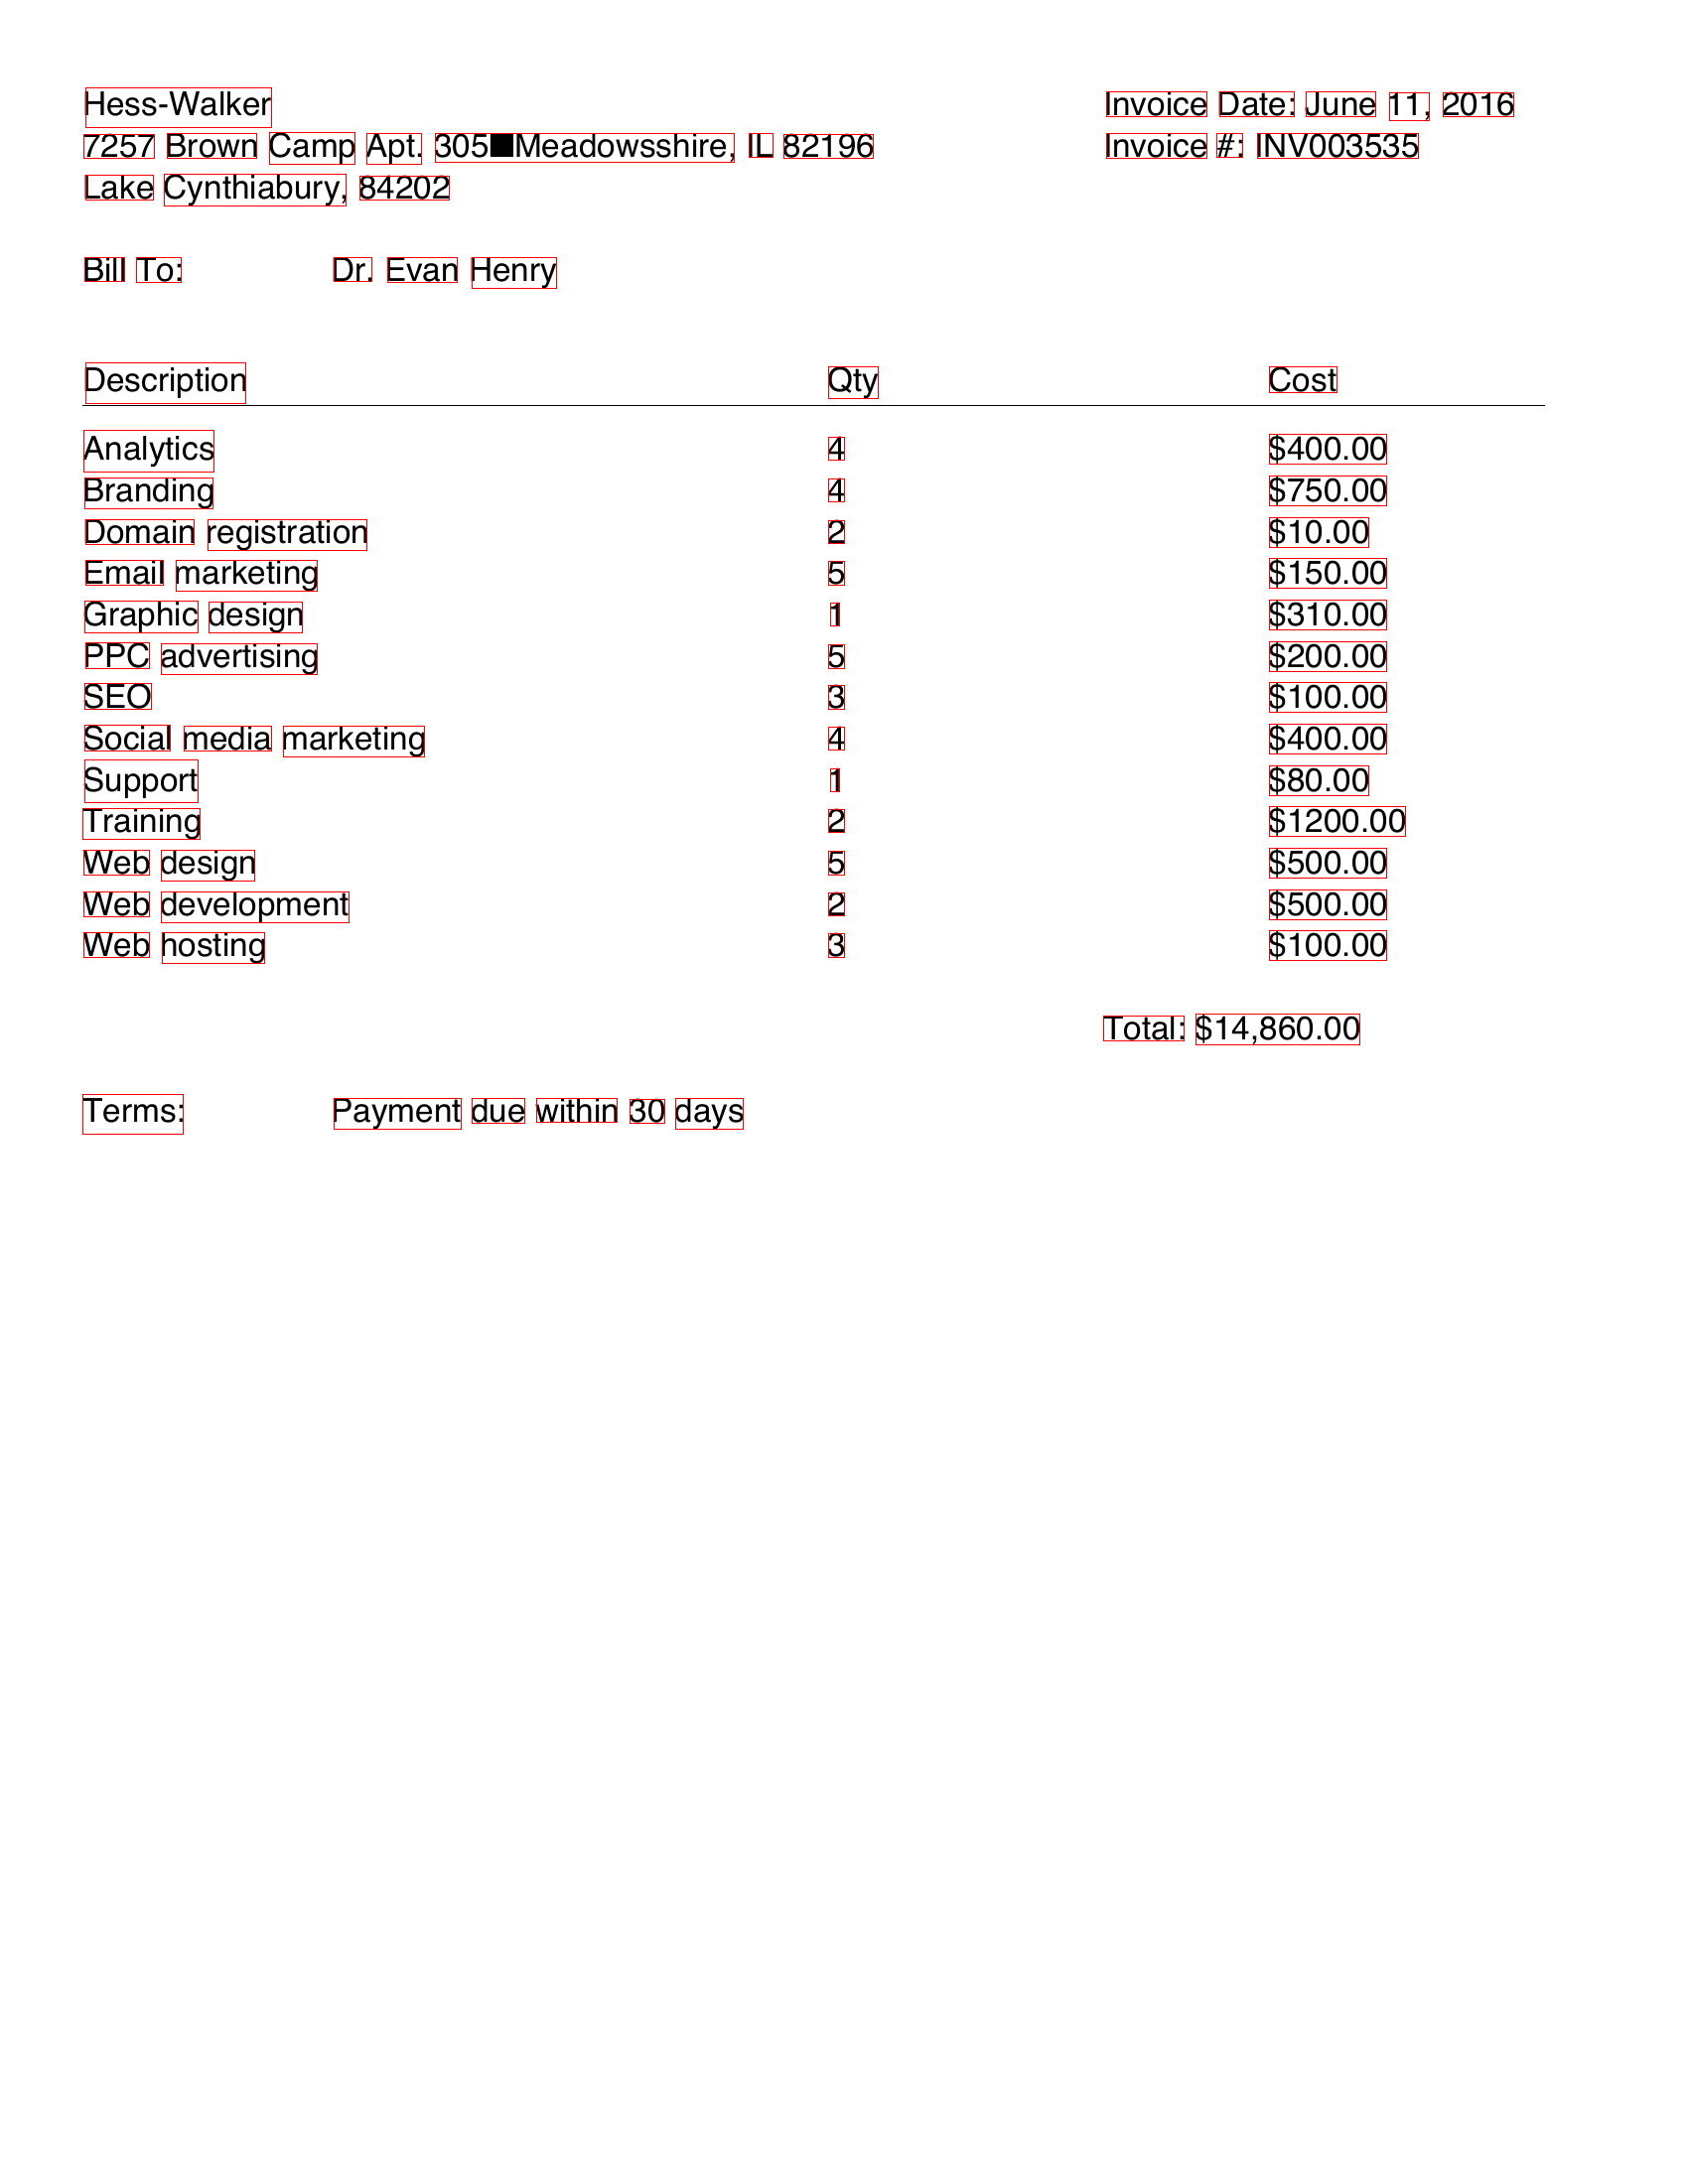

[{'position': [86, 88, 273, 128], 'text': 'Hess-Walker'},
 {'position': [1114, 92, 1215, 117], 'text': 'Invoice'},
 {'position': [1228, 92, 1303, 117], 'text': 'Date:'},
 {'position': [1315, 92, 1385, 117], 'text': 'June'},
 {'position': [1399, 93, 1439, 121], 'text': '11,'},
 {'position': [1453, 93, 1524, 117], 'text': '2016'},
 {'position': [168, 134, 258, 159], 'text': 'Brown'},
 {'position': [271, 133, 357, 165], 'text': 'Camp'},
 {'position': [369, 134, 424, 165], 'text': 'Apt.'},
 {'position': [438, 134, 739, 163], 'text': '305miMeadowsshire,'}]

In [158]:

from PIL import ImageDraw

def draw_boxes(image, response, outline='red'):
    """Draws boxes around text on the image"""
    draw = ImageDraw.Draw(image)
    for item in response:
        draw.rectangle(item['position'], outline=outline)
    return image
    
def grab_raw_data(image):
    # Use pytesseract to get the data
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    # Initialize the response list
    response = []

    # Loop over each item in the 'text' part of the data
    for i in range(len(data['text'])):
        if data['text'][i].strip() != '':  # This filters out empty text results
            x1, y1, width, height = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            x2, y2 = x1 + width, y1 + height
            
            # Here we don't have font information, so we'll omit that.
            # Pytesseract does not extract font family or size information.
            entry = {
                'position': [x1, y1, x2, y2],
                'text': data['text'][i]
            }
            response.append(entry)
    # sort response on [y1, x1] coordinates of the bounding boxes
    response_sorted = sorted(response, key=lambda k: [int(round(k['position'][1]/10)*10), k['position'][0]])

    # Now 'response' will be a list of dictionaries with the text and its bounding box coordinates.
    return response_sorted

response = grab_raw_data(image)
display(draw_boxes(image.copy(), response))
response[:10]


In [148]:
def merge_boxes(data, xtol, ytol):
    # Sort boxes based on x1 value (position[0])
    data.sort(key=lambda item: (item['position'][0], int(round(item['position'][1]/10)*10)))

    merged = True
    while merged:
        merged = False
        i = 0
        while i < len(data) - 1:
            box1 = data[i]['position']
            box2 = data[i + 1]['position']

            # Check if y1 values are within ytol and x2 of box1 and x1 of box2 are within xtol
            print(f'\nComparing box1: {box1} and box2: {box2}')
            if abs(box1[1] - box2[1]) <= ytol:
                print(f'+ ytol condition met: |{box1[1]} - {box2[1]}| = {abs(box1[1] - box2[1])}')
            if abs(box1[2] - box2[0]) <= xtol:
                print(f'+ xtol condition met: |{box1[2]} - {box2[0]}| = {abs(box1[2] - box2[0])}')
                
            if abs(box1[1] - box2[1]) <= ytol and abs(box1[2] - box2[0]) <= xtol:
                print(f'++ Merging box1: {box1} and box2: {box2}')
                # Merge boxes and concatenate text
                new_box = {
                    'position': [min(box1[0], box2[0]), min(box1[1], box2[1]), max(box1[2], box2[2]), max(box1[3], box2[3])],
                    'text': data[i]['text'] + ' ' + data[i + 1]['text']
                }
                data[i] = new_box
                del data[i + 1]
                merged = True
            else:
                i += 1

    data.sort(key=lambda item: item['position'][1])
    return data


xtol = 100  # Adjust this tolerance based on your requirement
ytol = 10   # Adjust this tolerance based on your requirement

n = 20
response_data = response.copy()
display(pd.DataFrame(response_data))
merged_data = merge_boxes(response_data,  xtol, ytol)
pd.DataFrame(merged_data)


,position,text
0,"[86, 88, 273, 128]",Hess-Walker
1,"[1114, 92, 1215, 117]",Invoice
2,"[1228, 92, 1303, 117]",Date:
3,"[1315, 92, 1385, 117]",June
4,"[1399, 93, 1439, 121]","11,"
...,...,...
78,"[336, 1106, 464, 1137]",Payment
79,"[475, 1106, 528, 1131]",due
80,"[540, 1106, 621, 1130]",within
81,"[634, 1107, 669, 1131]",30



Comparing box1: [83, 814, 201, 845] and box2: [83, 1102, 184, 1142]

Comparing box1: [83, 1102, 184, 1142] and box2: [84, 135, 155, 159]
+ xtol condition met: |184 - 84| = 100

Comparing box1: [84, 135, 155, 159] and box2: [84, 433, 215, 475]
+ xtol condition met: |155 - 84| = 71

Comparing box1: [84, 433, 215, 475] and box2: [84, 856, 150, 881]

Comparing box1: [84, 856, 150, 881] and box2: [84, 898, 150, 923]
+ xtol condition met: |150 - 84| = 66

Comparing box1: [84, 898, 150, 923] and box2: [84, 939, 150, 964]
+ xtol condition met: |150 - 84| = 66

Comparing box1: [84, 939, 150, 964] and box2: [85, 259, 125, 283]
+ xtol condition met: |150 - 85| = 65

Comparing box1: [85, 259, 125, 283] and box2: [85, 481, 214, 512]
+ xtol condition met: |125 - 85| = 40

Comparing box1: [85, 481, 214, 512] and box2: [85, 605, 199, 637]

Comparing box1: [85, 605, 199, 637] and box2: [85, 688, 152, 714]

Comparing box1: [85, 688, 152, 714] and box2: [85, 730, 171, 756]
+ xtol condition met: |152 - 8

,position,text
0,"[86, 88, 273, 128]",Hess-Walker
1,"[1114, 92, 1215, 117]",Invoice
2,"[1228, 92, 1303, 117]",Date:
3,"[1315, 92, 1524, 121]","June 11, 2016"
4,"[271, 133, 357, 165]",Camp
...,...,...
72,"[1204, 1021, 1369, 1052]","$14,860.00"
73,"[1111, 1023, 1192, 1048]",Total:
74,"[83, 1102, 184, 1142]",Terms:
75,"[336, 1106, 464, 1137]",Payment


In [162]:
def group_and_merge_boxes(data, xtol, ytol):
    # Step 1: Group boxes by lines
    lines = []
    for box in data:
        added_to_line = False
        for line in lines:
            if abs(line[0]['position'][1] - box['position'][1]) <= ytol:
                line.append(box)
                added_to_line = True
                break
        if not added_to_line:
            lines.append([box])

    # Step 2: Sort and merge within each line
    merged_data = []
    for line in lines:
        line.sort(key=lambda item: item['position'][0])  # Sort by x1
        i = 0
        while i < len(line) - 1:
            box1 = line[i]['position']
            box2 = line[i + 1]['position']
            if abs(box1[2] - box2[0]) <= xtol:  # Check horizontal proximity
                new_box = {'position': [min(box1[0], box2[0]), min(box1[1], box2[1]), max(box1[2], box2[2]), max(box1[3], box2[3])],
                           'text': line[i]['text'] + ' ' + line[i + 1]['text']}
                line[i] = new_box
                del line[i + 1]
            else:
                i += 1
        merged_data.extend(line)

    return merged_data

# Use this function with your pytesseract data
formatted_response = group_and_merge_boxes(response, xtol=20, ytol=5)

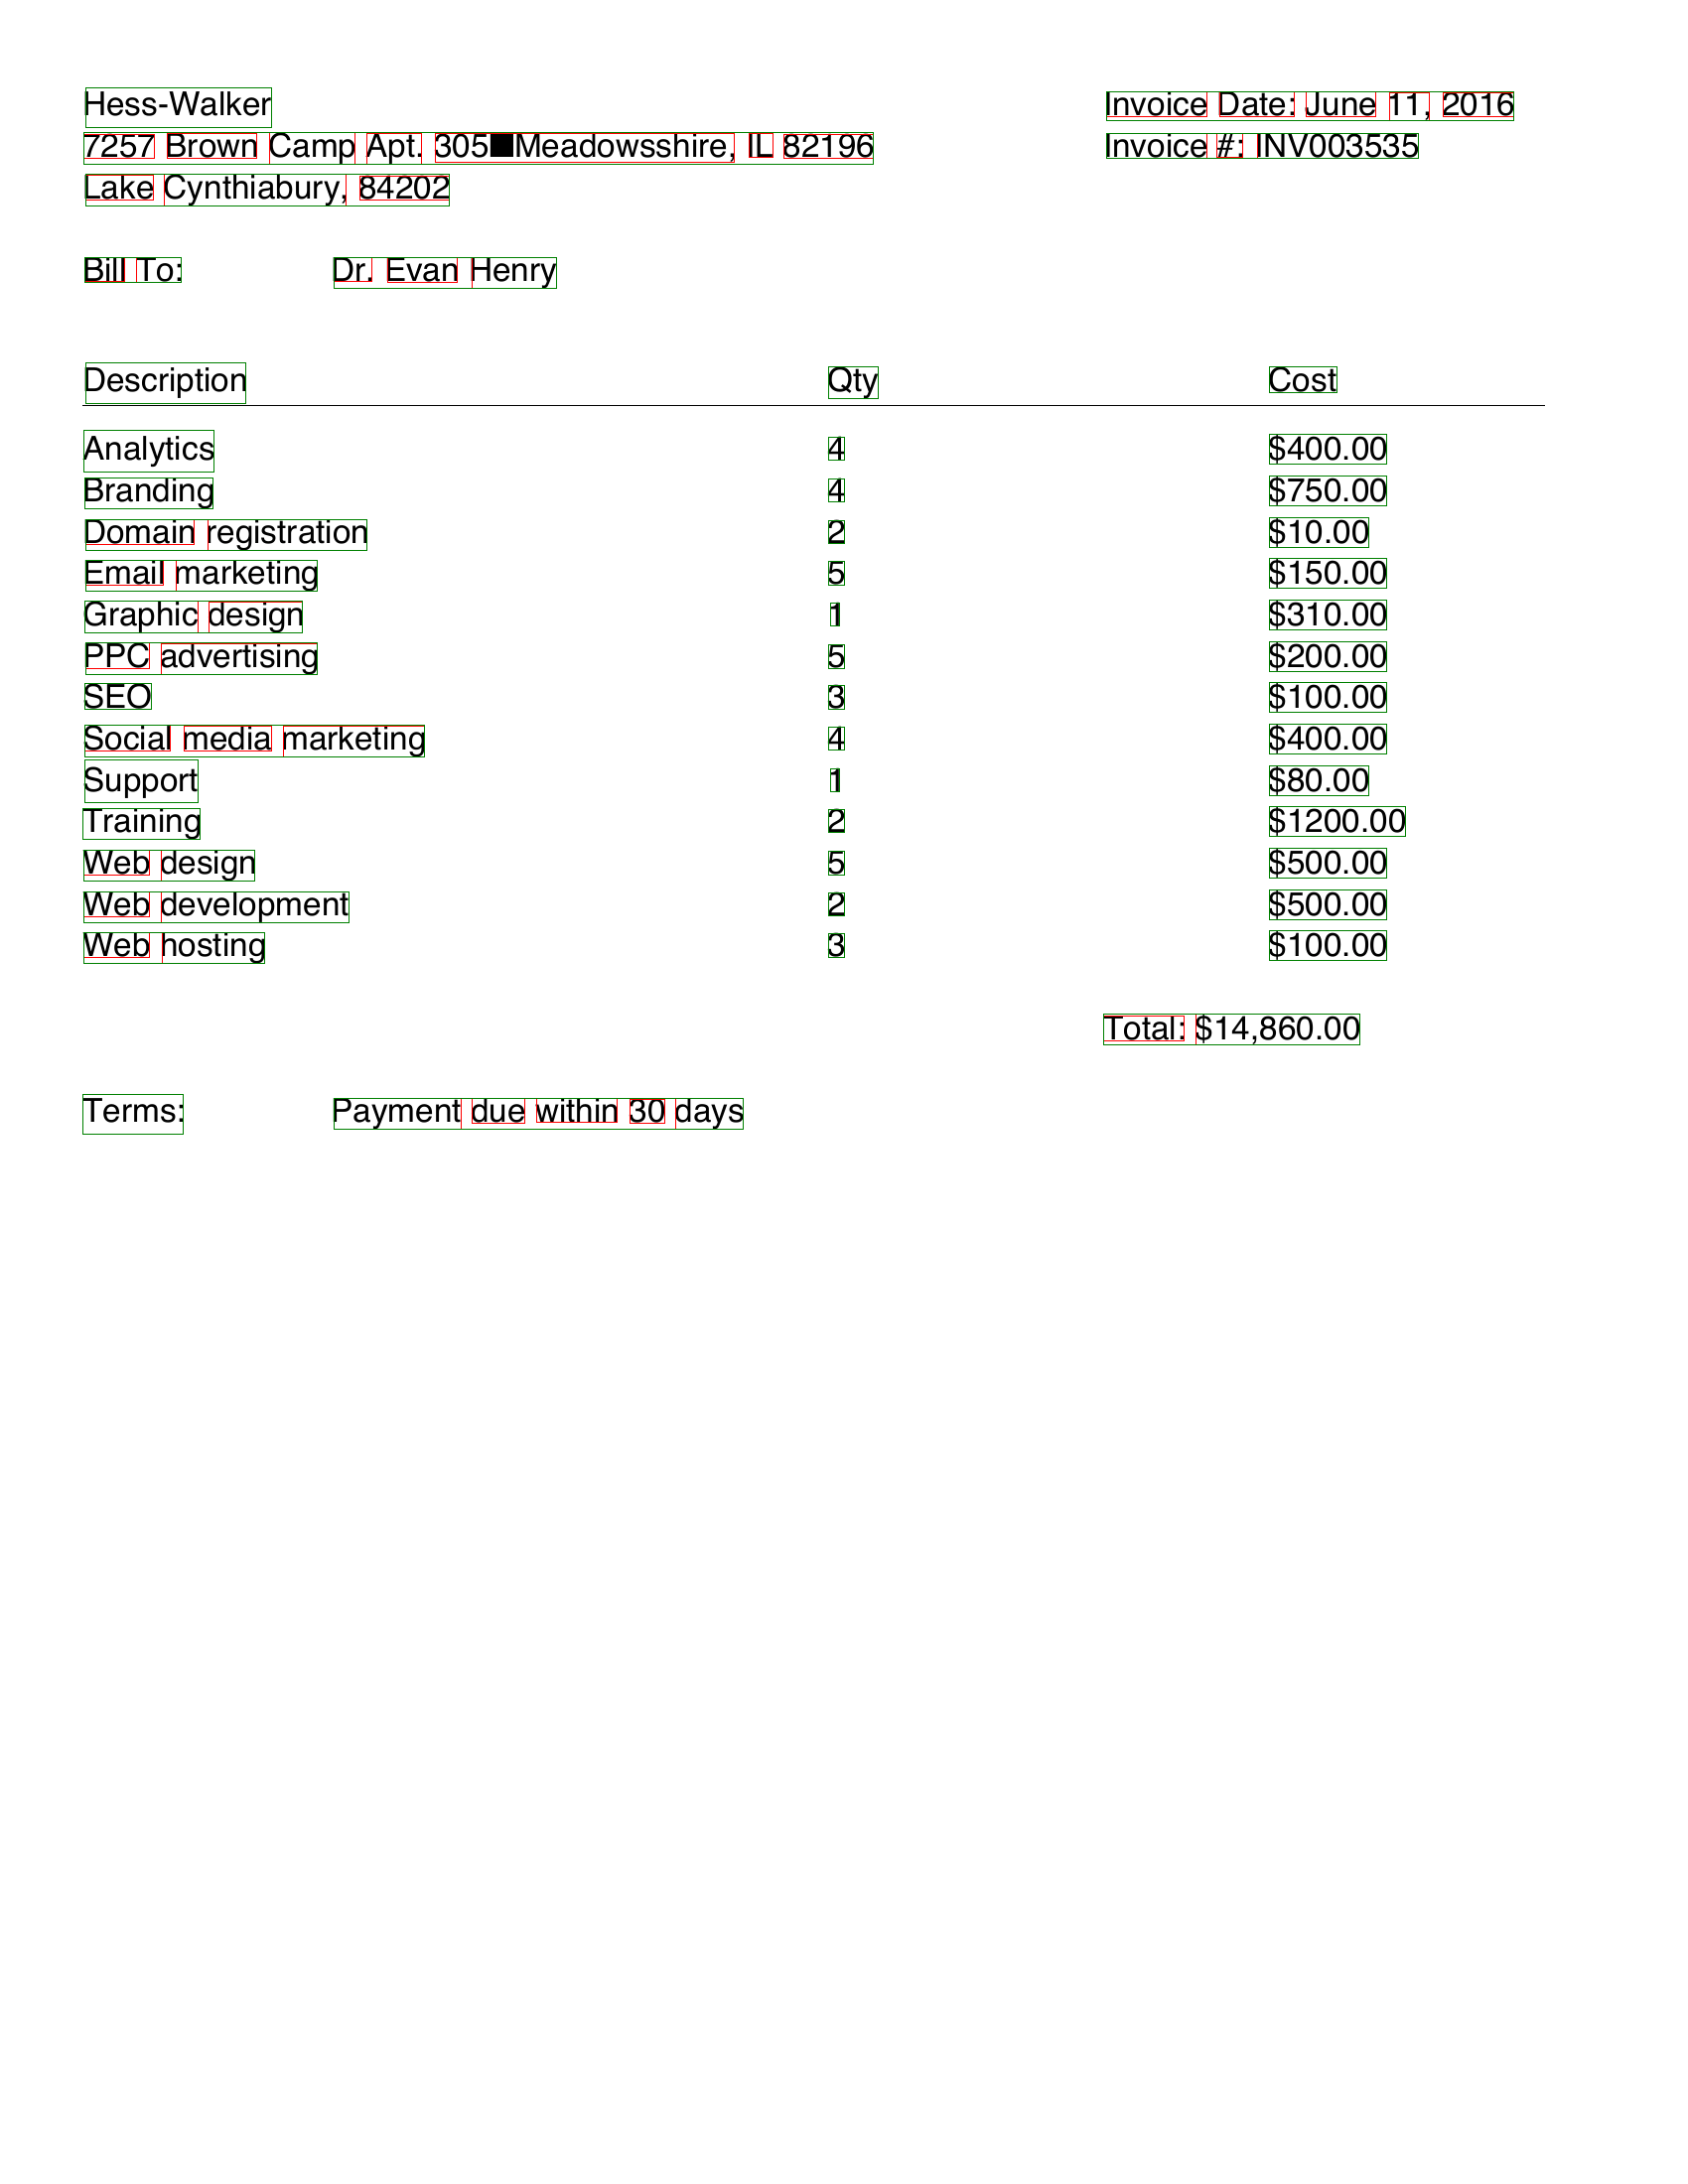

[{'position': [-117.0, 115.0, 384.0, 1162.0], 'text': 'Terms: 7257'},
 {'position': [-116.0, 836.0, 350.0, 943.0], 'text': 'Web Web'},
 {'position': [-116.0, 878.0, 350.0, 984.0], 'text': 'Web Web'},
 {'position': [-116.0, 239.0, 350.0, 984.0], 'text': 'Web Bill'},
 {'position': [-115.0, 668.0, 371.0, 776.0], 'text': 'SEO Social'},
 {'position': [-115.0, 710.0, 399.0, 828.0], 'text': 'Social Support'},
 {'position': [-115.0, 68.0, 473.0, 828.0], 'text': 'Support Hess-Walker'},
 {'position': [-114.0, 503.0, 395.0, 609.0], 'text': 'Domain Email'},
 {'position': [-114.0, 239.0, 382.0, 693.0], 'text': 'PPC To:'},
 {'position': [-38.0, 836.0, 551.0, 949.0], 'text': 'design development'},
 {'position': [-38.0, 878.0, 551.0, 990.0], 'text': 'development hosting'},
 {'position': [-37.0, 155.0, 548.0, 990.0], 'text': 'hosting Cynthiabury,'},
 {'position': [-35.0, 114.0, 548.0, 227.0], 'text': 'Cynthiabury, Brown'},
 {'position': [-15.0, 503.0, 569.0, 776.0], 'text': 'media registration'},
 {'po

In [161]:

image_copy = image.copy()
draw_boxes(image_copy, scaled_data, outline='red')
draw_boxes(image_copy, formatted_response, outline='green')
display(image_copy)

merged_data